
📊 Classification Report for Rain Prediction Model
              precision    recall  f1-score   support

           0       0.85      0.98      0.91        57
           1       0.86      0.38      0.52        16

    accuracy                           0.85        73
   macro avg       0.85      0.68      0.72        73
weighted avg       0.85      0.85      0.83        73

✅ Accuracy: 84.93%

Weather Forecast for Patiāla, IN
Rain Tomorrow Prediction: Yes

📈 Temperature & Humidity Forecast for Next 5 Hours:
Time      Temperature (°C)    Humidity (%)
--------------------------------------------------
01:00     28.18               34.3
02:00     20.44               37.26
03:00     22.21               36.42
04:00     22.67               47.29
05:00     24.97               47.21


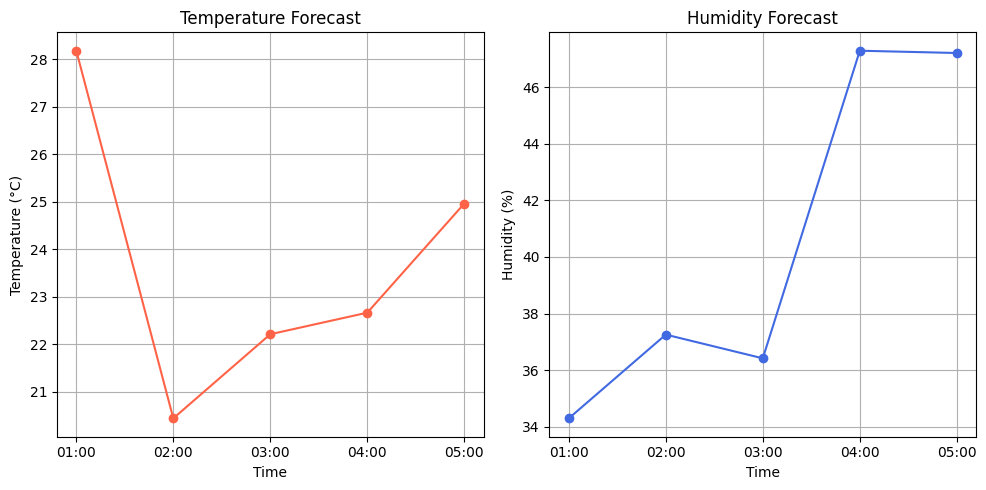

In [10]:
import requests
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report
from datetime import datetime, timedelta
import pytz
import matplotlib.pyplot as plt

API_KEY = '035f22b5abc2a87591034d2cebc9935b'
BASE_URL = 'https://api.openweathermap.org/data/2.5/'

def get_current_weather(city):
    url = f"{BASE_URL}weather?q={city}&appid={API_KEY}&units=metric"
    response = requests.get(url)
    data = response.json()
    if response.status_code != 200 or 'main' not in data:
        print(f"❌ Error fetching weather: {data.get('message', 'Unknown error')}")
        return None

    return {
        'city': data.get('name', city),
        'current_temp': round(data['main'].get('temp', 0)),
        'feels_like': round(data['main'].get('feels_like', 0)),
        'temp_min': round(data['main'].get('temp_min', 0)),
        'temp_max': round(data['main'].get('temp_max', 0)),
        'humidity': round(data['main'].get('humidity', 0)),
        'description': data['weather'][0].get('description', 'Not available'),
        'country': data['sys'].get('country', 'N/A'),
        'WindGustDir': 'N',  # default
        'WindGustSpeed': data['wind'].get('gust', 30),
        'Pressure': data['main'].get('pressure', 1012),
        'Temp': round(data['main'].get('temp', 0))
    }

def read_historical_data(filename):
    df = pd.read_csv(filename)
    df = df.dropna()
    df = df.drop_duplicates()
    return df

def prepare_data(data):
    all_directions = ['N', 'S', 'E', 'W', 'NE', 'NW', 'SE', 'SW',
                      'ENE', 'WSW', 'ESE', 'NNW', 'NNE', 'SSW', 'SSE', 'WNW']

    le = LabelEncoder()
    le.fit(all_directions)
    data['WindGustDir'] = le.transform(data['WindGustDir'])
    data['RainTomorrow'] = LabelEncoder().fit_transform(data['RainTomorrow'])

    x = data[['MinTemp', 'MaxTemp', 'WindGustDir', 'WindGustSpeed', 'Humidity', 'Pressure', 'Temp']]
    y = data['RainTomorrow']

    return x, y, le

def train_rain_model(x, y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    print("\n📊 Classification Report for Rain Prediction Model")
    print(classification_report(y_test, y_pred))
    print(f"✅ Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")

    return model

def prepare_regression_data(data, feature):
    x, y = [], []
    for i in range(len(data) - 1):
        x.append(data[feature].iloc[i])
        y.append(data[feature].iloc[i + 1])

    x = np.array(x).reshape(-1, 1)
    y = np.array(y)
    return x, y

def train_regression_model(x, y):
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(x, y)
    return model

def predict_future(model, current_value):
    predictions = [current_value]
    for i in range(5):
        next_value = model.predict(np.array([[predictions[-1]]]))
        predictions.append(next_value[0])
    return predictions[1:]

def weather_view():
    while True:
        city = input("🏙️ Enter any city name: ").strip()
        if city:
            break
        print("⚠️ Please enter a valid city name.")

    current_weather = get_current_weather(city)
    if current_weather is None:
        print("⚠️ Exiting due to failed weather fetch.")
        return

    historical_data = read_historical_data("D:\\projects\\nexshell\\weather.csv")
    x, y, le = prepare_data(historical_data)
    rain_model = train_rain_model(x, y)

    try:
        wind_dir_encoded = le.transform([current_weather['WindGustDir']])[0]
    except:
        wind_dir_encoded = le.transform(['N'])[0]  # fallback

    current_data = {
        'MinTemp': current_weather['temp_min'],
        'MaxTemp': current_weather['temp_max'],
        'WindGustDir': wind_dir_encoded,
        'WindGustSpeed': current_weather['WindGustSpeed'],
        'Humidity': current_weather['humidity'],
        'Pressure': current_weather['Pressure'],
        'Temp': current_weather['Temp']
    }
    

    current_df = pd.DataFrame([current_data])
    rain_prediction = rain_model.predict(current_df)[0]

    x_temp, y_temp = prepare_regression_data(historical_data, 'Temp')
    x_hum, y_hum = prepare_regression_data(historical_data, 'Humidity')

    temp_model = train_regression_model(x_temp, y_temp)
    hum_model = train_regression_model(x_hum, y_hum)

    future_temp = predict_future(temp_model, current_weather['Temp'])
    future_hum = predict_future(hum_model, current_weather['humidity'])

    timezone = pytz.timezone('Asia/Kolkata')
    now = datetime.now(timezone)
    next_hour = now + timedelta(hours=1)
    next_hour = next_hour.replace(minute=0, second=0, microsecond=0)
    future_times = [(next_hour + timedelta(hours=i)).strftime("%H:00") for i in range(5)]

    print(f"\nWeather Forecast for {current_weather['city']}, {current_weather['country']}")
    print(f"Rain Tomorrow Prediction: {'Yes' if rain_prediction == 1 else 'No'}")
    print("\n📈 Temperature & Humidity Forecast for Next 5 Hours:")
    print(f"{'Time':<10}{'Temperature (°C)':<20}{'Humidity (%)'}")
    print("-" * 50)
    for t, temp, hum in zip(future_times, future_temp, future_hum):
        print(f"{t:<10}{round(temp, 2):<20}{round(hum, 2)}")

     # ✅ Plotting only if everything above succeeded
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(future_times, future_temp, marker='o', color='tomato')
    plt.title('Temperature Forecast')
    plt.xlabel('Time')
    plt.ylabel('Temperature (°C)')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(future_times, future_hum, marker='o', color='royalblue')
    plt.title('Humidity Forecast')
    plt.xlabel('Time')
    plt.ylabel('Humidity (%)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()


weather_view()